In [1]:
%load_ext autoreload
%autoreload 2

import torch

from d3dv.datasets import get_dataset
from d3dv.models import get_model
from d3dv.geometry.viz_2d import plot_images, plot_keypoints, plot_matches, cm_RdGn
from d3dv.geometry.utils import to_homogeneous, from_homogeneous, T_to_E, sym_epipolar_distance

torch.set_grad_enabled(False);

### Configure and create a dataloader (here MegaDepth)

In [2]:
conf = {'two_view': True, 'seed': 9, 'resize': 1024}
dataset = get_dataset('megadepth')(conf)
loader = dataset.get_data_loader('val')

[03/08/2020 23:19:44 INFO] Creating dataset MegaDepth
[03/08/2020 23:19:44 INFO] Sampling new images or pairs with seed 9
100%|██████████| 77/77 [00:01<00:00, 53.61it/s]


### Create a matching pipeline: SuperPoint -> NN matcher

In [3]:
conf = {
    'extractor': {
        'name': 'superpoint',
        'max_num_keypoints': 1024,
    },
    'matcher': {
        'name': 'nearest_neighbor_matcher',
        'mutual_check': True,
        'distance_thresh': 0.7,
    }
}
model = get_model('two_view_pipeline')(conf)

### Get one element and run a forward pass

In [4]:
data = next(iter(loader))
pred = model(data)
print(data.keys())
print(pred.keys())

dict_keys(['name0', 'image0', 'image_size0', 'depth0', 'K0', 'T_w_to_cam0', 'name1', 'image1', 'image_size1', 'depth1', 'K1', 'T_w_to_cam1', 'T_0to1', 'T_1to0'])
dict_keys(['keypoints0', 'keypoint_scores0', 'descriptors0', 'keypoints1', 'keypoint_scores1', 'descriptors1', 'matches0'])


### Plot matches and keypoints

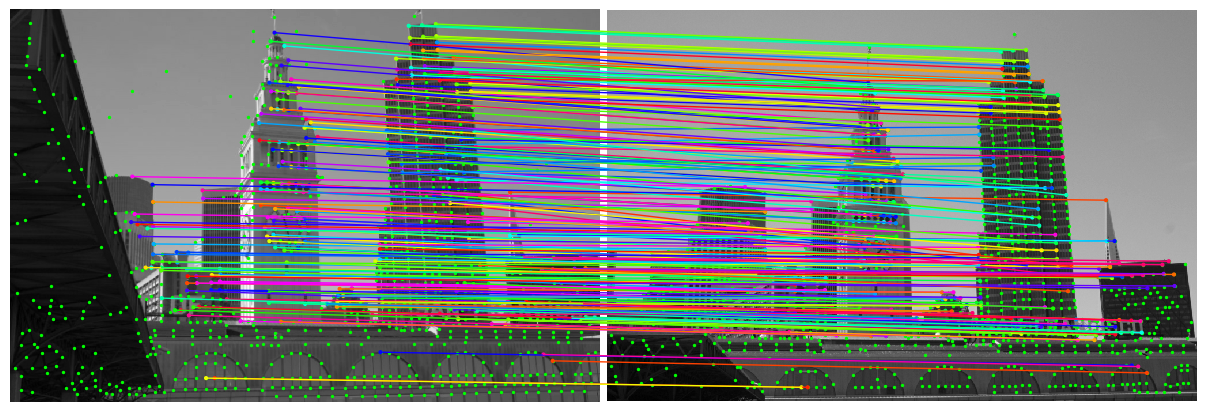

In [5]:
kp0, kp1, m0 = pred['keypoints0'], pred['keypoints1'], pred['matches0']
kpm0 = kp0[0][m0[0]>-1]
kpm1 = kp1[0][m0[0][m0[0]>-1]]

plot_images([data['image0'][0, 0], data['image1'][0, 0]])
plot_keypoints([kp0[0], kp1[0]], colors='lime')
plot_matches(kpm0, kpm1, lw=1, ps=4)

### Evaluate using the epipolar distance

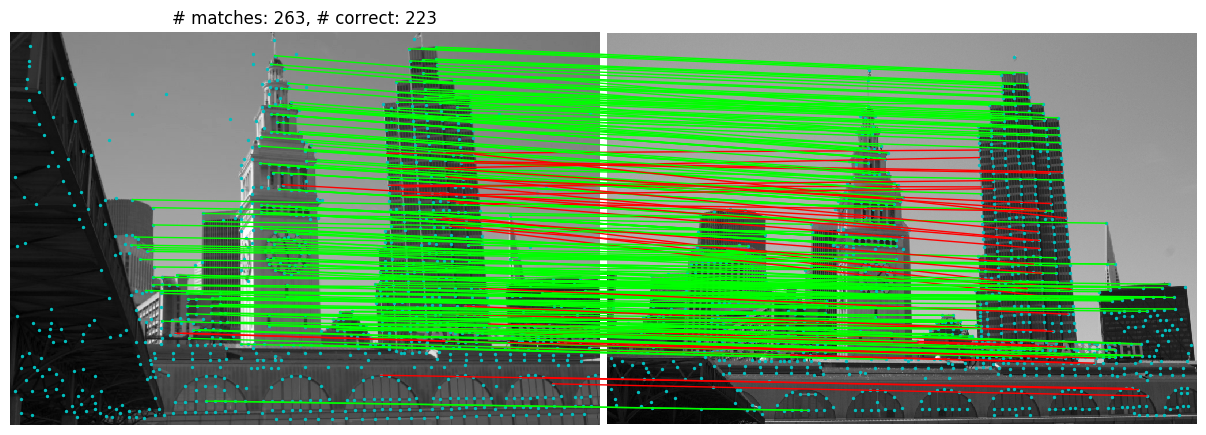

In [6]:
E = T_to_E(data['T_0to1'][0])
p0 = to_homogeneous(kpm0) @ data['K0'][0].inverse().T
p1 = to_homogeneous(kpm1) @ data['K1'][0].inverse().T
d = sym_epipolar_distance(p0, p1, E)
correct = d.numpy() < 1e-4
color = cm_RdGn(correct).tolist()

plot_images([data['image0'][0, 0], data['image1'][0, 0]],
            titles=[f'# matches: {len(d)}, # correct: {correct.sum()}', ''])
plot_keypoints([kp0[0], kp1[0]], colors='c')

plot_matches(kp0[0][m0[0]>-1], kp1[0][m0[0][m0[0]>-1]], color, lw=1, ps=0)